In [1]:
import sys
sys.path.insert(0, "./../../scripts")

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def imshowbar(fig,ax,A,showbar=True,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    if showbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(imsh, cax=cax, orientation="vertical")
        return cbar

In [3]:
plt.rcParams["font.sans-serif"] = ["PT Sans","DejaVu Sans"]

# Plot Exact and Partitioned Mean Rates From Supp Fig S4a,b

In [6]:
from scipy.interpolate import UnivariateSpline
from dmft import basesubwrapnorm
from scipy.interpolate import interp1d

gaus = np.linspace(0,90,91)
hwhm = np.zeros_like(gaus)

def calc_HWHM(data,n):
    itp = UnivariateSpline(np.arange(-n//2,n//2)/n*180,np.concatenate((data[-n//2:],data[:n//2])),s=0)
    half = (itp(0) - 0)/2 + 0
    roots = UnivariateSpline(np.linspace(-60,60,121),itp(np.linspace(-60,60,121))-half,s=0).roots()
    width = 0.5*np.abs(roots[1]-roots[0])
    return width

for idx,s in enumerate(gaus):
    if np.isclose(s,0):
        hwhm[idx] = 0
    else:
        data = basesubwrapnorm(np.arange(180)*180/180,s)
        hwhm[idx] = calc_HWHM(data,180)

hwhm_itp = interp1d(gaus,hwhm)

In [ ]:
from dmft import struct_fact

widths = np.linspace(5,50,10)

z0s = struct_fact(0,np.sqrt(widths[:,None]**2+widths[None,:]**2),widths[:,None])
z90s = struct_fact(90,np.sqrt(widths[:,None]**2+widths[None,:]**2),widths[:,None])

In [7]:
from dmft import wrapnormdens
from scipy.integrate import dblquad

hwhms = hwhm_itp(widths)

def part_fact0(z,skern,hwhm,L=180):
    return dblquad(lambda y,x: wrapnormdens(x-y+z,skern,L),-hwhm,hwhm,-hwhm,hwhm)[0] * 2*np.pi / 180 / (2*hwhm)
def part_fact90(z,skern,hwhm,L=180):
    return dblquad(lambda y,x: wrapnormdens(x-y+z,skern,L),-hwhm,hwhm,hwhm,180-hwhm)[0] * 2*np.pi / 180 / (2*(90-hwhm))
vpart_fact0 = np.vectorize(part_fact0)
vpart_fact90 = np.vectorize(part_fact90)

p0s = vpart_fact0(0,widths[None,:],hwhms[:,None])
p90s = vpart_fact90(0,widths[None,:],hwhms[:,None])

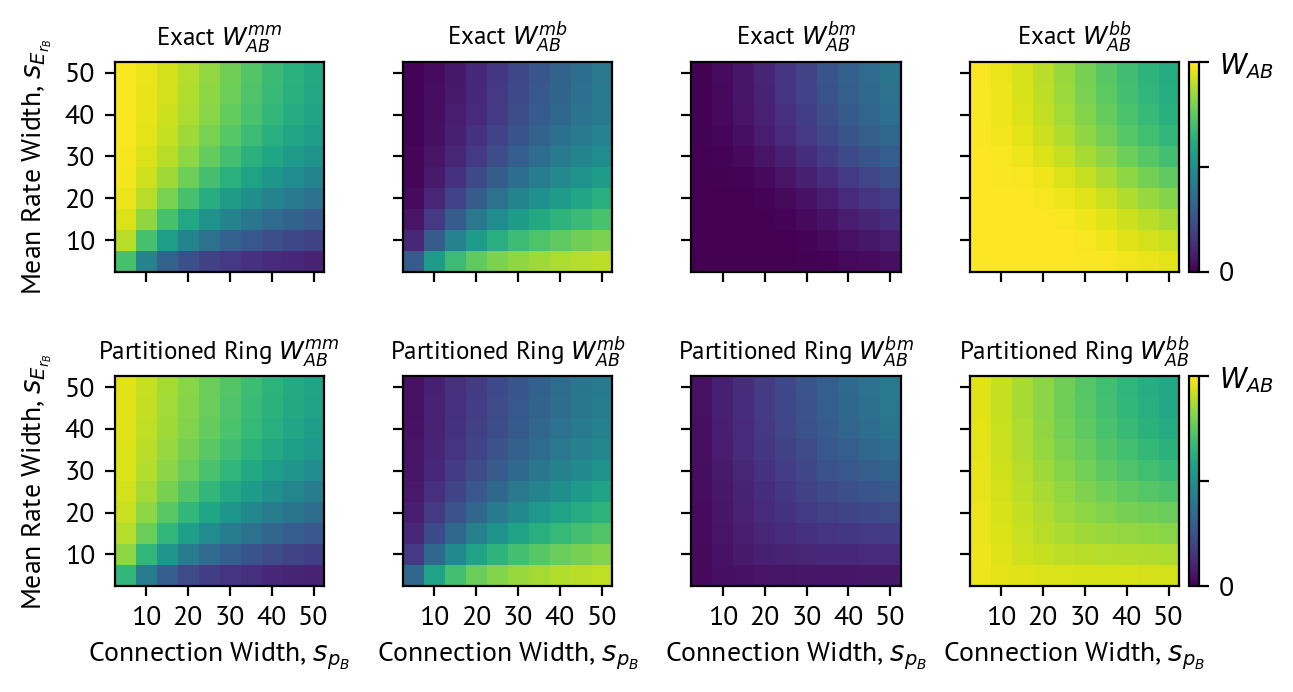

In [ ]:
fig,axs = plt.subplots(2,4,figsize=(1.8*4,1.7*2),dpi=200,sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.15,hspace=0.5)

imshowbar(fig,axs[0,0],z0s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
imshowbar(fig,axs[0,1],1-z0s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
imshowbar(fig,axs[0,2],z90s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
cbar = imshowbar(fig,axs[0,3],1-z90s,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
cbar.ax.set_yticks([0,0.5,1],["0","",r"$W_{AB}$"])
imshowbar(fig,axs[1,0],p0s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
imshowbar(fig,axs[1,1],1-p0s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
imshowbar(fig,axs[1,2],p90s,showbar=False,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
cbar = imshowbar(fig,axs[1,3],1-p90s,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
cbar.ax.set_yticks([0,0.5,1],["0","",r"$W_{AB}$"])

axs[0,0].set_xticks([10,20,30,40,50])
axs[0,0].set_yticks([10,20,30,40,50])

for i in range(4):
    axs[1,i].set_xlabel(r"Connection Width, $s_{p_B}$")
axs[0,0].set_ylabel(r"Mean Rate Width, $s_{E_{r_B}}$")
axs[1,0].set_ylabel(r"Mean Rate Width, $s_{E_{r_B}}$")

axs[0,0].set_title(r"Exact $W_{AB}^{mm}$",fontsize=9)
axs[0,1].set_title(r"Exact $W_{AB}^{mb}$",fontsize=9)
axs[0,2].set_title(r"Exact $W_{AB}^{bm}$",fontsize=9)
axs[0,3].set_title(r"Exact $W_{AB}^{bb}$",fontsize=9)
axs[1,0].set_title(r"Partitioned Ring $W_{AB}^{mm}$",fontsize=9)
axs[1,1].set_title(r"Partitioned Ring $W_{AB}^{mb}$",fontsize=9)
axs[1,2].set_title(r"Partitioned Ring $W_{AB}^{bm}$",fontsize=9)
axs[1,3].set_title(r"Partitioned Ring $W_{AB}^{bb}$",fontsize=9)

# fig.tight_layout()
fig.savefig("./supp_fig_4ab.pdf")

# Plot Spectral Radius of Cross-Site Weights Divided by Within-Site Weights From Supp Fig S4c

In [10]:
def spect_rad(z0,z90):
    wpp = z0
    wpb = 1-z0
    wbp = z90
    wbb = 1-z90
    
    return np.max(np.real(np.linalg.eigvals(np.linalg.inv(np.array([[wpp,0],[0,wbb]]))@np.array([[0,wpb],[wbp,0]]))))
vspect_rad = np.vectorize(spect_rad)

z_spect_rads = vspect_rad(z0s,z90s)
p_spect_rads = vspect_rad(p0s,p90s)

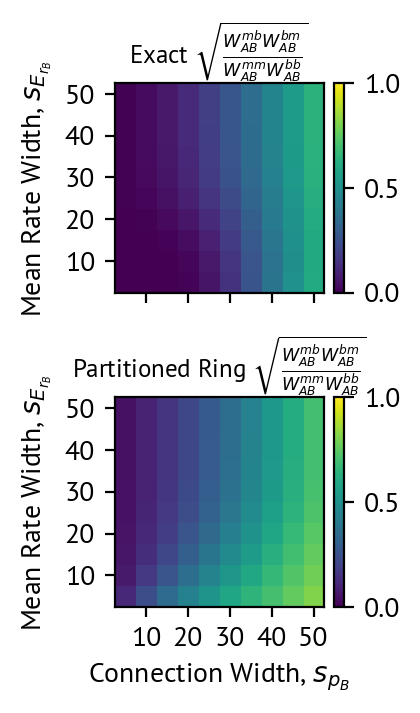

In [ ]:
fig,axs = plt.subplots(2,1,figsize=(1.8*1,1.7*2),dpi=200,sharex=True,sharey=True)
fig.subplots_adjust(wspace=0.15,hspace=0.5)

imshowbar(fig,axs[0],z_spect_rads,showbar=True,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))
imshowbar(fig,axs[1],p_spect_rads,showbar=True,origin="lower",vmin=0,vmax=1,extent=(2.5,52.5,2.5,52.5))

axs[0].set_xticks([10,20,30,40,50])
axs[0].set_yticks([10,20,30,40,50])

axs[1].set_xlabel(r"Connection Width, $s_{p_B}$")
axs[0].set_ylabel(r"Mean Rate Width, $s_{E_{r_B}}$")
axs[1].set_ylabel(r"Mean Rate Width, $s_{E_{r_B}}$")

axs[0].set_title(r"Exact $\sqrt{\frac{W_{AB}^{mb} W_{AB}^{bm}}{W_{AB}^{mm} W_{AB}^{bb}} }$",fontsize=9)
axs[1].set_title(r"Partitioned Ring $\sqrt{\frac{W_{AB}^{mb} W_{AB}^{bm}}{W_{AB}^{mm} W_{AB}^{bb}} }$",fontsize=9)

# fig.tight_layout()
fig.savefig("./supp_fig_4c.pdf")